<a href="https://colab.research.google.com/github/adarshmodh/Deep-Learning-Projects/blob/master/Karpathy_Makemore_2_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# read in all the words
words = open('/content/drive/MyDrive/names.txt', 'r').read().splitlines()
words[:8], len(words)

(['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'],
 32033)

In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


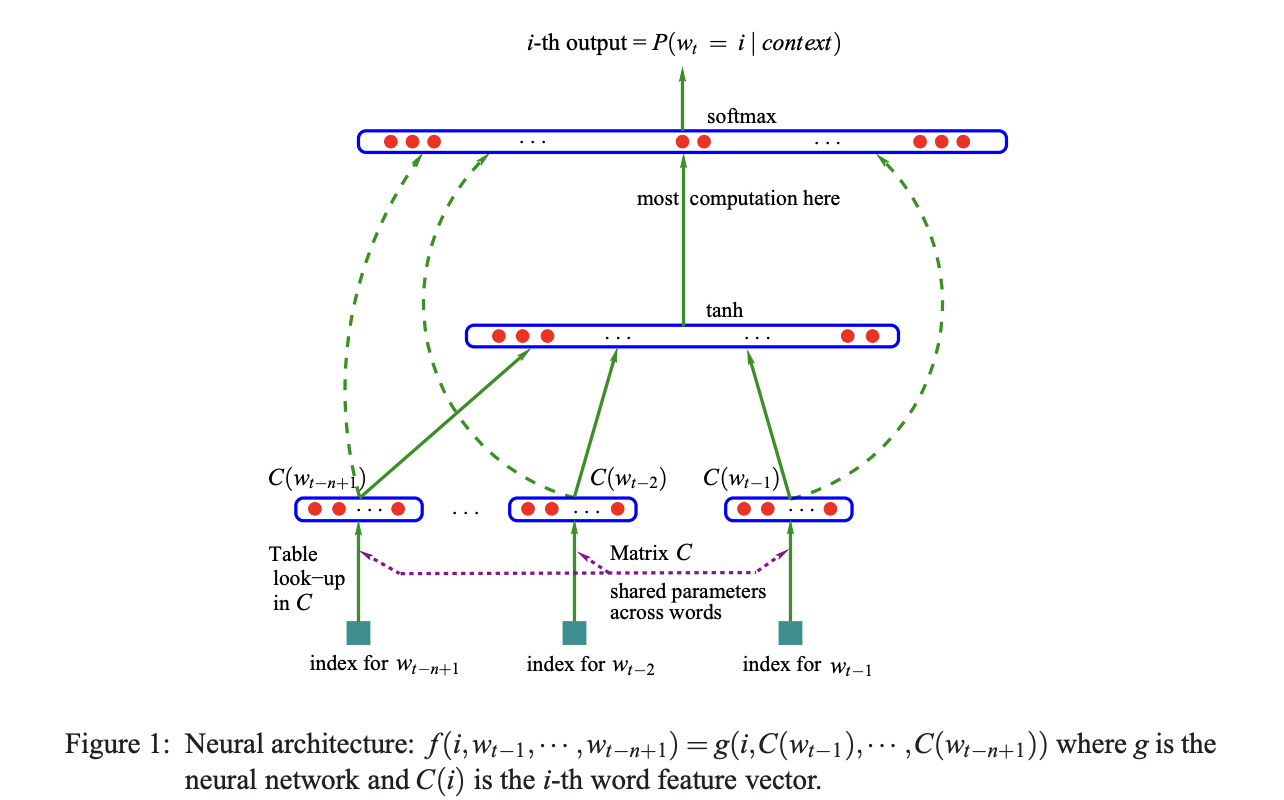

In [ ]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words: # just using 5 words for illustration
  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)


In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [ ]:
C = torch.randn((27,2))
C[5]
# it can be thought of a integer indexing into a lookup table
# or equivalently they are the weight matrix for the first input layer of the neural network

tensor([-0.1352, -0.5327])

In [ ]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.1352, -0.5327])

In [ ]:
X[13,2], C[X][13,2], C[1]

(tensor(1), tensor([-1.2905,  0.2880]), tensor([-1.2905,  0.2880]))

In [ ]:
C[X].shape

torch.Size([32, 3, 2])

In [ ]:
emb = C[X] #pytorch indexing is cool, makes a embedding of all the integers in X

In [ ]:
# initializing the weights and biases
W1 = torch.randn(6, 100)  # num of inputs is 6 (3 instances of 2 chars), hidden layer has 100 neurons
b1 = torch.randn(100)
print(emb.view(32,6).shape) # the most efficient operation for reshaping a torch tensor, torch.cat uses new memory

h = emb.view(emb.shape[0],6) @ W1 + b1
h = torch.tanh(h)


torch.Size([32, 6])


In [ ]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)
logits = h @ W2 + b2
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
probs.shape, probs[0].sum() #normalized probabilities - softmax

(torch.Size([32, 27]), tensor(1.))

In [ ]:
loss = -probs[torch.arange(32), Y].log().mean()
loss.item()

25.268451690673828

In [ ]:
# Figuring out learning rate
print(X.shape, Y.shape)
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((6, 100), generator=g, requires_grad=True)
b1 = torch.randn(100, generator=g, requires_grad=True)
W2 = torch.randn((100, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

# learning rate - how to figure out whats a good rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lri = []
lossi = []
stepi = []

for i in range (1000):
  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32,))

  # forward pass
  emb = C[X[ix]]
  h = emb.view(emb.shape[0],6) @ W1 + b1
  h = torch.tanh(h)
  logits = h @ W2 + b2
  # counts = logits.exp()
  # probs = counts / counts.sum(1, keepdims=True)
  # loss = -probs[torch.arange(32), Y].log().mean()
  loss = F.cross_entropy(logits, Y[ix]) # replacing softmax with inbuilt cross_entropy
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None

  loss.backward()
  # update
  lr = lrs[i]
  # lr = 0.1
  for p in parameters:
    p.data += -lr * p.grad

  #track stats
  lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())



torch.Size([228146, 3]) torch.Size([228146])


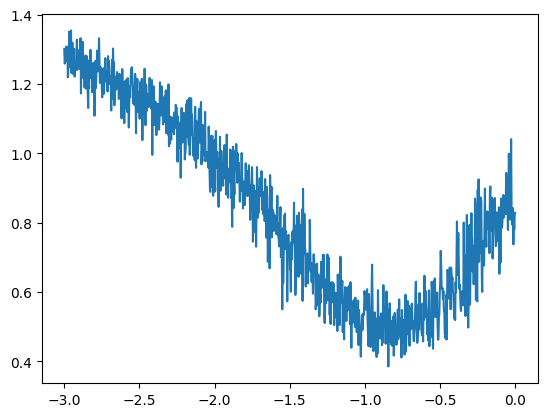

In [ ]:
plt.plot(lri, lossi)

# we conclude using this graph that lr = 0.1 (lrs = 10 Lr) was a good rate

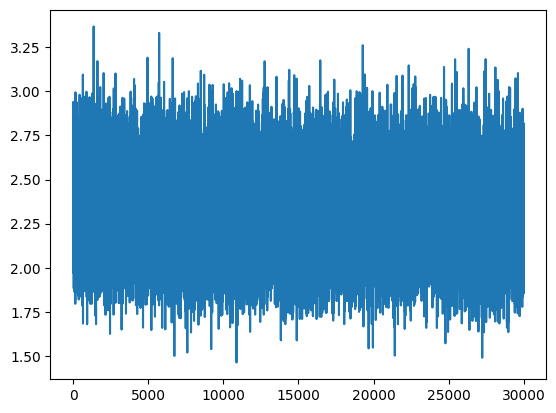

In [ ]:
# loss doesnt improve because the embedding vectors are only 2 dimensional
plt.plot(stepi, lossi)

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # training
Xdev, Ydev = build_dataset(words[n1:n2]) # validation
Xte, Yte = build_dataset(words[n2:]) # testing

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [ ]:
# updating the embedding layer to 10, and hidden layer 300
print(Xtr.shape, Ytr.shape)
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g, requires_grad=True)
W1 = torch.randn((30, 200), generator=g, requires_grad=True)
b1 = torch.randn(200, generator=g, requires_grad=True)
W2 = torch.randn((200, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]
lossi = []
stepi = []

torch.Size([182580, 3]) torch.Size([182580])


In [ ]:
# Actual training loop
max_steps = 150000
batch_size = 32

for i in range (max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb]
  h = emb.view(emb.shape[0],-1) @ W1 + b1
  h = torch.tanh(h)
  logits = h @ W2 + b2
  # counts = logits.exp()
  # probs = counts / counts.sum(1, keepdims=True)
  # loss = -probs[torch.arange(32), Y].log().mean()
  loss = F.cross_entropy(logits, Yb) # replacing softmax with inbuilt cross_entropy
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None

  loss.backward()
  # update
  lr = 0.1 if i < max_steps/2 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  #track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  stepi.append(i)
  lossi.append(loss.log10().item())


      0/ 100000: 28.8956
  10000/ 100000: 2.6427
  20000/ 100000: 2.2125
  30000/ 100000: 2.7605
  40000/ 100000: 2.1276
  50000/ 100000: 2.2980
  60000/ 100000: 2.1610
  70000/ 100000: 2.1007
  80000/ 100000: 1.8028
  90000/ 100000: 2.4033


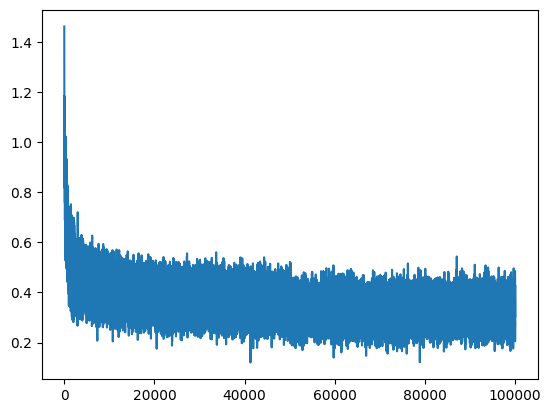

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(f'validation loss = {loss.item()}')

with torch.no_grad():
  # testing loss
  emb = C[Xtr] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr)
  print(f'testing loss = {loss.item()}')


validation loss = 2.1992807388305664
testing loss = 2.1647653579711914


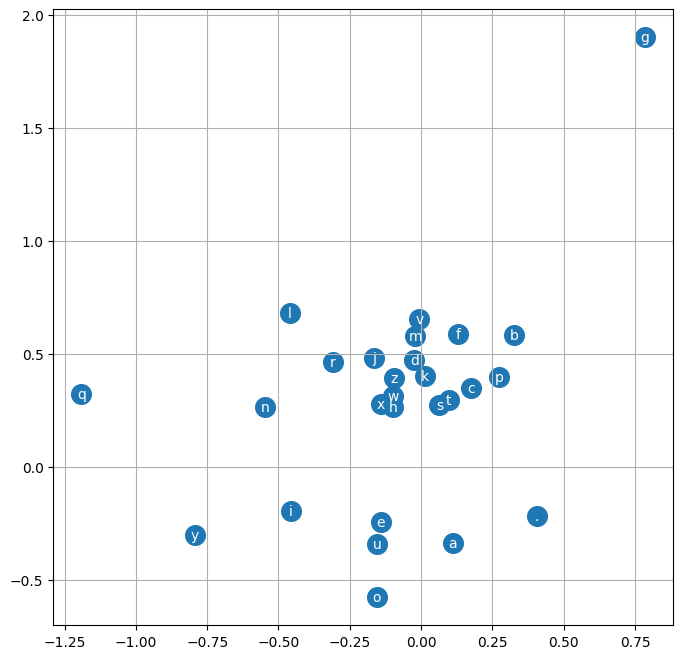

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# sample (inference) from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

carmah.
amorie.
khi.
mili.
taty.
salaysie.
rahner.
amerynci.
aqui.
nellara.
chaiir.
kaleigh.
ham.
joce.
quinn.
salin.
alianni.
watelo.
dearyni.
jace.
